In [170]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io as sio
import xarray as xr

from tqdm import tqdm, notebook

import sys
sys.path.append('../util/')
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import time

import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
import os, glob
from netCDF4 import Dataset

# temporarily defines all the enironmental variables to test the codee
os.environ['DATADIR'] = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001' 
os.environ['obs_lat_distrib_file'] = '/localdrive/drive10/jj/mdtf/inputdata/obs_data/etc_composites/erai_lat_distrib.pkl' 
os.environ['FIRSTYR'] = '2008' 
os.environ['LASTYR'] = '2012' 
os.environ['topo_file'] = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/topo.nc' 
os.environ['POD_HOME'] = '/localdrive/drive10/jj/mdtf/MDTF-diagnostics/diagnostics/etc_composites' 
os.environ['WK_DIR'] = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites' 
os.environ['CASENAME'] = 'GFDL.EXP1.2PM.001' 
    
import defines
import datetime as dt

import xarray as xr
import pandas as pd

import pdb

import pickle
# from tqdm import tqdm

import sys
sys.path.append(os.environ['POD_HOME']+'/util')

import composites
import reader

import random
random.seed(0)

In [171]:
# The PW categories are: 0-11 mm, 11-19 mm, more than 19 mm
# the ascent strength categories: less than -6.8 hPa/hr, -6.8 to -4.7 and between -4.7 and 0. 

prw_bins = [0, 11, 19, 999]
w500_bins = [-999, -6.8, -4.7, 0]


In [172]:
# var_list = ['tp', 'wap500', 'clt', 'slp', 'cls850']
var_list = defines.composite_var_list
to_folder = defines.data_folder
if (not os.path.exists(to_folder)): 
  os.makedirs(to_folder)
for var in var_list: 
  search_string = os.path.join(defines.var_data_directory, f'{var}.*.nc')
  print(search_string)
  for tmp_file in glob.glob(search_string):
    tmp_file = os.path.basename(tmp_file)
    from_file = os.path.join(defines.var_data_directory, tmp_file)
    to_file =  os.path.join(to_folder, tmp_file)
    cmd = f'ln -s {from_file} {to_file}'
    os.system(cmd)

print('Done symlinking the data files...')

/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites/tmp/data_converts/tp.*.nc
/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites/tmp/data_converts/prw.*.nc
/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites/tmp/data_converts/w500.*.nc
/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites/tmp/data_converts/uv10.*.nc
/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v14.001_2008_2012/etc_composites/tmp/data_converts/clt.*.nc
Done symlinking the data files...


In [173]:
# defining the years to run the code for 
year_list = range(defines.composite_years[0], defines.composite_years[1]+1)

# land mask 
ds = xr.open_dataset(defines.topo_file)
if ('time' in ds.coords.keys()): 
  lm = ds.lsm.isel(time=0).values
else: 
  lm = ds.lsm.values
lm = (lm > defines.thresh_landsea)
ds.close()

# defining the dimensions of the composite values 
circ_dist_bins = np.arange(0, defines.circ['dist_max']+defines.circ['dist_div'], defines.circ['dist_div'])
circ_ang_bins = np.arange(-180., 180+defines.circ['ang_div'], defines.circ['ang_div'])*np.pi/180
circ_H_sum = np.zeros((len(circ_ang_bins)-1, len(circ_dist_bins)-1))
circ_H_cnt = np.zeros((len(circ_ang_bins)-1, len(circ_dist_bins)-1))

area_dist_bins = np.arange(-defines.area['dist_max'], defines.area['dist_max']+defines.area['dist_div'], defines.area['dist_div'])
area_H_sum = np.zeros((len(area_dist_bins)-1, len(area_dist_bins)-1))
area_H_cnt = np.zeros((len(area_dist_bins)-1, len(area_dist_bins)-1))

In [174]:
# composite analysis creating init variables
# ciruclar average, and area average
comp = {}
for hemis in defines.composite_hem_list: 
  comp[hemis] = {}
  for lm_type in ['land', 'ocean']: 
    comp[hemis][lm_type] = {}
    for season in ['all', 'djf', 'mam', 'jja', 'son', 'warm']:
      comp[hemis][lm_type][season] = {}
      for var in defines.composite_var_list:
        comp[hemis][lm_type][season][var] = {}
        comp[hemis][lm_type][season][var]['circ_sum'] = np.zeros(circ_H_sum.shape)
        comp[hemis][lm_type][season][var]['circ_cnt'] = np.zeros(circ_H_cnt.shape)
        comp[hemis][lm_type][season][var]['area_sum'] = np.zeros(area_H_sum.shape)
        comp[hemis][lm_type][season][var]['area_cnt'] = np.zeros(area_H_cnt.shape)
        
comp['FW_sum'] = np.zeros((len(prw_bins), len(w500_bins), area_H_sum.shape[0], area_H_sum.shape[1]))
comp['FW_cnt'] = np.zeros((len(prw_bins), len(w500_bins), area_H_cnt.shape[0], area_H_cnt.shape[1]))
comp['FW_cases'] = np.zeros((len(prw_bins), len(w500_bins)))

In [175]:
# Read in the lat distribution from ERA-Interim/OBS
obs_distrib = pickle.load(open(os.environ['obs_lat_distrib_file'], 'rb'))

# Randomly sample the dataset so that the bins have the same pct 
actual_obs_pct = obs_distrib['obs_pct']
actual_all_pct = obs_distrib['all_pct']

In [176]:
# loop through all the years and create the composite
for year in year_list: 

    # SLP data as the sample dataset
    # getting the reference longitude and latitude values
    slp_file = os.path.join(defines.var_data_directory, f'slp.{year}.nc')
    slp = xr.open_dataset(slp_file)
    reflon = slp.lon.values
    reflat = slp.lat.values

    # creating the co-ordinate grid
    lon, lat = np.meshgrid(reflon, reflat)

    # opening all the necessary variables to create the composites for
    ds_list = {}
    for var in defines.composite_var_list: 
        var_file = os.path.join(defines.var_data_directory, f'{var}.{year}.nc')
        ds_list[var] = xr.open_dataset(var_file)
  
    ############# Get Centers for the given date ######################
    in_file = os.path.join(defines.read_folder, f'{defines.model}_{year}.mat')
    all_centers = reader.read_center_from_mat_file(in_file)
    if (not isinstance(slp.indexes['time'], pd.core.indexes.datetimes.DatetimeIndex)):
        datetimeindex = slp.indexes['time'].to_datetimeindex()
    else:
        datetimeindex = slp.indexes['time']

    ############ This portion of the code is used to match the latitude distriubtion from the observations 
    # to the model data

    # Trying to match the lat distrib of the cases with ERA-Interim
    all_lat = all_centers['lat']
    all_lon = all_centers['lon']
    all_obs_flag = all_centers['obs_flag']
    all_select_flag = all_centers['all_select_flag']
    obs_select_flag = all_centers['obs_select_flag']

    # bining all the center lat from the model data
    bins = np.arange(-60, 60, 5)
    minlength = len(bins)+1
    model_full_lat_ind = np.digitize(all_lat, bins=bins)
    model_full_lat_bin_counts = np.bincount(model_full_lat_ind, minlength=minlength)

    # create the pct distrib of model for all centers
    model_all_ind = (np.abs(all_lat) > 30) & (np.abs(all_lat) < 60)
    model_all_lat_ind = np.digitize(all_lat[model_all_ind], bins=bins)
    model_all_lat_bin_counts = np.bincount(model_all_lat_ind, minlength=minlength)
    model_all_pct = model_all_lat_bin_counts/np.sum(model_all_lat_bin_counts)
    model_all_pct[model_all_pct == 0] = np.nan

    # getting the number of samples that I need to select for each lat bin
    model_all_tot_counts = model_all_lat_bin_counts/actual_all_pct
    total_all_model_count = np.nanmin(model_all_tot_counts)
    # model_all_min_ind = np.nanargmin(model_all_pct)
    # model_all_min_count = model_all_lat_bin_counts[model_all_min_ind]
    # actual_all_min_pct = actual_all_pct[model_all_min_ind]
    # total_all_model_count = model_all_min_count/actual_all_min_pct
    model_all_new_distrib = actual_all_pct*total_all_model_count
    model_all_new_distrib[np.isnan(model_all_new_distrib)] = 0
    model_all_new_distrib = np.array(model_all_new_distrib, dtype=np.int) 

    # create the pct distrib of model for SH Ocean Warm 
    model_obs_ind = (np.abs(all_lat) > 30) & (np.abs(all_lat) < 60) & (all_obs_flag == 1)
    bins = np.arange(-60, 60, 5)
    model_obs_lat_ind = np.digitize(all_lat[model_obs_ind], bins=bins)
    model_obs_lat_bin_counts = np.bincount(model_obs_lat_ind, minlength=minlength)
    model_obs_pct = model_obs_lat_bin_counts/np.sum(model_obs_lat_bin_counts)
    model_obs_pct[model_obs_pct == 0] = np.nan

    # getting the number of samples that I need to select for each lat bin
    model_obs_tot_counts = model_obs_lat_bin_counts/actual_obs_pct
    total_obs_model_count = np.nanmin(model_obs_tot_counts)
    # model_obs_min_ind = np.nanargmin(model_obs_pct)
    # model_obs_min_count = model_obs_lat_bin_counts[model_obs_min_ind]
    # actual_obs_min_pct = actual_obs_pct[model_obs_min_ind]
    # total_obs_model_count = model_obs_min_count/actual_obs_min_pct
    model_obs_new_distrib = actual_obs_pct*total_obs_model_count
    model_obs_new_distrib[np.isnan(model_obs_new_distrib)] = 0
    model_obs_new_distrib = np.array(model_obs_new_distrib, dtype=np.int) 

    # sampling the model distribution to match the values
    model_indexes = np.arange(0, len(all_lat))
    for i in range(1, len(bins)+1): 
        # setting up the all_select_flag
        tmp_ind = (model_full_lat_ind == i) & (model_all_ind)
        tmp_indexes = model_indexes[tmp_ind].tolist()
        sample_ind = random.sample(tmp_indexes, model_all_new_distrib[i])
        all_select_flag[sample_ind] = 1

        # setting up the obs_select_flag
        tmp_ind = (model_full_lat_ind == i) & (model_obs_ind)
        tmp_indexes = model_indexes[tmp_ind].tolist()
        sample_ind = random.sample(tmp_indexes, model_obs_new_distrib[i])
        obs_select_flag[sample_ind] = 1

    # setting the flags for which centers to use under 
    # distributions that match the enitre erai lat distrib 
    # and selected SH Warm Ocean lat distrib
    all_centers['all_select_flag'] = all_select_flag
    all_centers['obs_select_flag'] = obs_select_flag

    # loop through all time steps in the year
    for t_step in notebook.tqdm(range(1, len(slp.time))):

#         stime = time.time()
        # creating a datetime variable for the current time step
        # date = pd.Timestamp(slp.time[t_step].values).to_pydatetime()
        date = datetimeindex[t_step].to_pydatetime()
        # print(date)

        # getting the season for the given time step date
        t_step_month = date.month
        if (t_step_month == 12) | (t_step_month == 1) | (t_step_month == 2):
            t_season = 'djf'
        elif (t_step_month == 3) | (t_step_month == 4) | (t_step_month == 5):
            t_season = 'mam'
        elif (t_step_month == 6) | (t_step_month == 7) | (t_step_month == 8):
            t_season = 'jja'
        elif (t_step_month == 9) | (t_step_month == 10) | (t_step_month == 11):
            t_season = 'son'

        t_season_warm = False
        if (t_step_month == 11) | (t_step_month == 12) | (t_step_month == 1) | (t_step_month == 2) | (t_step_month == 3):
            t_season_warm = True

        # check if the t_season is requested in the defines.py
        # atleast 'all' should be given in the season_list
        if ('all' not in defines.composite_season_list) & (t_season not in defines.composite_season_list) & ('warm' not in defines.composite_season_list):
            continue

        fd_date = date
        centers = all_centers.find_centers_for_date(fd_date)
        
#         print(f"Done setup: {time.time() - stime} seconds");

        # looping through all the centers for the given data
        for i_center, _  in enumerate(centers.lat): 
#             stime = time.time()
            date_str = fd_date.strftime('%Y%m%d%H')

            center = {}
            for key in centers.keys():
                center[key] = centers[key][i_center]

            # skip all cyclones close to the equator or poles
            if (np.abs(center['lat']) > 60) | (np.abs(center['lat']) < 30): 
                continue

            if (center['lat'] >= 0):
                hemis_type = 'NH'
            elif (center['lat'] < 0): 
                hemis_type = 'SH'

            if (center['lm_flag']): 
                lm_type = 'land'
            else:
                lm_type = 'ocean'

#             if (center['obs_select_flag'] == 1.0):
            if (hemis_type == 'SH') & (lm_type == 'ocean') & (t_season_warm):
                ds_tstep = ds_list['prw'].isel(time=t_step)
                prw = ds_tstep['prw'].values
                ds_tstep = ds_list['w500'].isel(time=t_step)
                w500 = ds_tstep['w500'].values
                ds_tstep = ds_list['clt'].isel(time=t_step)
                clt = ds_tstep['clt'].values
                w500 = composites.area_avg_one_step(lat, lon, w500, center['lat'], center['lon'], bins=(area_dist_bins, area_dist_bins))
                prw = composites.area_avg_one_step(lat, lon, prw, center['lat'], center['lon'], bins=(area_dist_bins, area_dist_bins))
                clt = composites.area_avg_one_step(lat, lon, clt, center['lat'], center['lon'], bins=(area_dist_bins, area_dist_bins))

                w500 = w500.sum/w500.cnt
                prw = prw.sum/prw.cnt
                mean_w500 = np.nanmean(w500[w500 < 0]) * 3600/100 # converting from Pa/s to hPa/hr
                mean_prw = np.nanmean(prw) 
                
                prw_ind = np.digitize(mean_prw, bins=prw_bins)
                w500_ind = np.digitize(mean_w500, bins=w500_bins)
                comp['FW_sum'][prw_ind-1, w500_ind-1, :, :] += clt.sum
                comp['FW_cnt'][prw_ind-1, w500_ind-1, :, :] += clt.cnt
                comp['FW_cases'][prw_ind-1, w500_ind-1] += 1
            
            # if this particular center is not selected as either part of all or SH ocean warm distrib skip this center
            if (center['all_select_flag'] == 0.0) & (center['obs_select_flag'] == 0.0):
                continue

            for var in defines.composite_var_list: 
                ds_tstep = ds_list[var].isel(time=t_step)
                data = ds_tstep[var].values

                area_H = composites.area_avg_one_step(lat, lon, data, center['lat'], center['lon'], bins=(area_dist_bins, area_dist_bins))
                # if this is part of the all distrib we include it in our composites
                if (center['all_select_flag'] == 1.0):
                    comp[hemis_type][lm_type]['all'][var]['area_sum'] += area_H.sum
                    comp[hemis_type][lm_type]['all'][var]['area_cnt'] += area_H.cnt

                    comp[hemis_type][lm_type][t_season][var]['area_sum'] += area_H.sum
                    comp[hemis_type][lm_type][t_season][var]['area_cnt'] += area_H.cnt

                # if this is part of the SH Ocean Warm distrib we include it in our composites, only if the obs_select_flag is set
                if (t_season_warm):
                    if (hemis_type == 'SH') & (lm_type == 'ocean'):
                        if (center['obs_select_flag'] == 1.0):
                            comp[hemis_type][lm_type]['warm'][var]['area_sum'] += area_H.sum
                            comp[hemis_type][lm_type]['warm'][var]['area_cnt'] += area_H.cnt
                    else:
                        if (center['all_select_flag'] == 1.0):
                            comp[hemis_type][lm_type]['warm'][var]['area_sum'] += area_H.sum
                            comp[hemis_type][lm_type]['warm'][var]['area_cnt'] += area_H.cnt


        # end t_step
#         if (t_step > 100):
#             break

    # end year
#     break

# saving the data files 
comp['x'] = area_H.x
comp['y'] = area_H.y
comp['x_edges'] = area_H.x_edges
comp['y_edges'] = area_H.y_edges 
# pickle.dump(comp, open(os.path.join(defines.read_folder, 'composites.pkl'), 'wb'))

for hemis_type in defines.composite_hem_list:
  for var in defines.composite_var_list:
    for season in defines.composite_season_list:
      for lm_type in ['land', 'ocean']:

        tmp_dict = comp[hemis_type][lm_type][season][var]

        # plt.close('all')
        # tmp = tmp_dict['circ_sum']/tmp_dict['circ_cnt']
        # composites.plot_polar(circ_H.y,  circ_H.x, tmp)
        #ERA-Interim plt.title(f'{var.upper()} {lm_type} {hemis_type}')
        # out_file = os.path.join(defines.images_folder, f'{defines.model}_{defines.over_write_years[0]}_{defines.over_write_years[1]}_circ_{var}_{hemis_type}_{lm_type}.png')
        # plt.savefig(out_file, dpi=300.)

#         plt.close('all')
#         tmp = tmp_dict['area_sum']/tmp_dict['area_cnt']
#         composites.plot_area(area_H.y_edges,  area_H.x_edges, tmp)
#         plt.title(f'{var.upper()} {lm_type} {hemis_type}')
#         # out_file = os.path.join(defines.images_folder, f'{defines.model}_{defines.over_write_years[0]}_{defines.over_write_years[1]}_area_{var}_{hemis_type}_{lm_type}_{season.upper()}.png')
#         out_file = os.path.join(defines.model_images_folder, f'{os.environ["CASENAME"]}_area_{var}_{hemis_type}_{lm_type}_{season.upper()}.png')
#         plt.title(f'{os.environ["CASENAME"]} {var.upper()} [{hemis_type.upper()}-{lm_type.upper()}-{season.upper()}]')
#         plt.savefig(out_file, dpi=100.)

In [177]:
out = {'prw_bins': prw_bins, 'w500_bins': w500_bins, 'comp': comp}
# pickle.dump(out, open('fw_data_using_distrib.pkl', 'wb'))
pickle.dump(out, open('fw_data_using_all.pkl', 'wb'))

In [178]:
print(comp['FW_sum'].shape)
print(np.arange(-1.5+.5, 1.5+.1, .1))

(4, 4, 30, 30)
[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00]


# Load and plot figure

In [ ]:
# in_data = pickle.load(open('fw_data_using_distrib.pkl', 'rb'))
in_data = pickle.load(open('fw_data_using_all.pkl', 'rb'))
prw_bins = in_data['prw_bins']
w500_bins = in_data['w500_bins']
comp = in_data['comp']


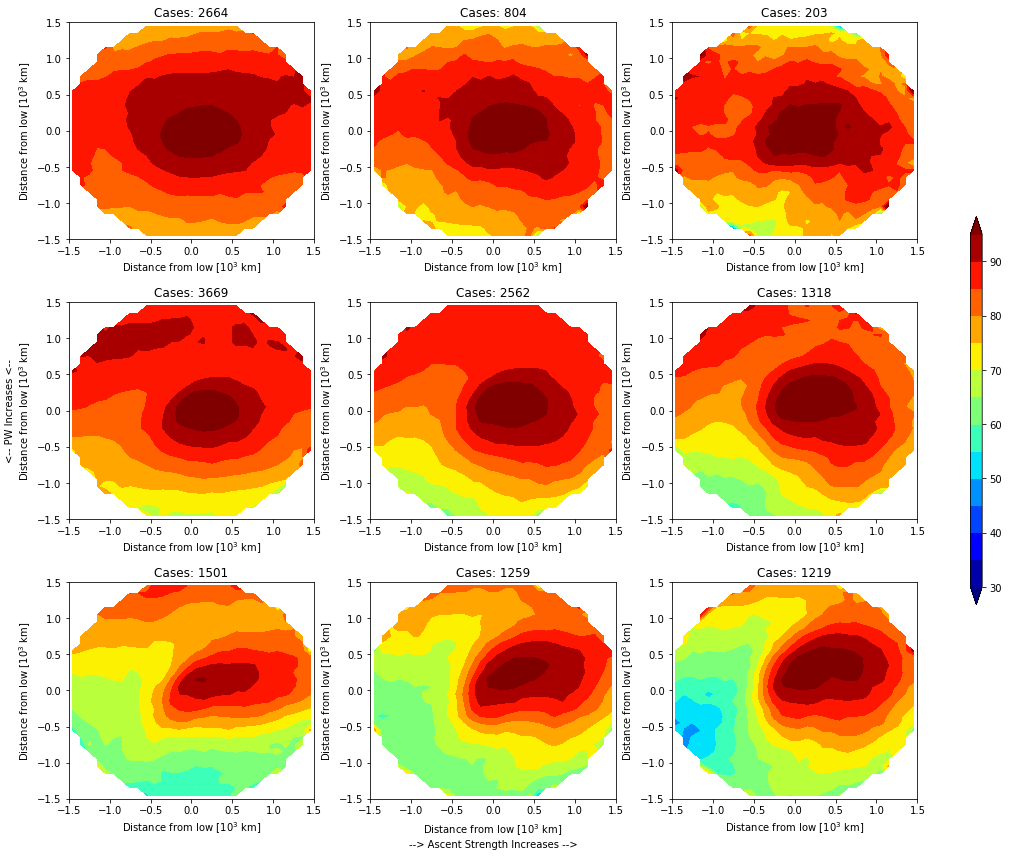

In [179]:
dist_arr = np.arange(-1.5+.05, 1.5+.05, .1)
plt.figure(figsize=(16, 12))
ax_list = []
for i in range(len(prw_bins)-1): 
    for j in range(len(w500_bins)-1): 
        ax = plt.subplot2grid((3,3), (i,2-j))
        ax_list.append(ax)
        tmp = comp['FW_sum']/comp['FW_cnt']
        pc = plt.contourf(dist_arr, dist_arr, tmp[i,j,:,:], cmap='jet', levels=np.arange(30, 100, 5), extend='both')
#         pc = plt.pcolormesh(dist_arr, dist_arr, tmp[i,j,:,:], cmap='jet', vmin=30, vmax=100)
#         plt.title(f"PRW: {prw_bins[i]:.1f}mm/hr - {prw_bins[i+1]:.1f}mm/hr\n W500: {w500_bins[j]}hPa/hr - {w500_bins[j+1]}hPa/hr\n Cases: {comp['FW_cases'][i, j]:.0f}")
        plt.title(f"Cases: {comp['FW_cases'][i, j]:.0f}")
        if (i == 1) & (j == 2):
            plt.ylabel('<-- PW Increases <--\nDistance from low [{0} km]'.format(r'10$^3$'))
        else:
            plt.ylabel(r'Distance from low [10$^3$ km]')
        if (i == 2) & (j == 1):
            plt.xlabel('Distance from low [{0} km]\n--> Ascent Strength Increases -->'.format(r'10$^3$'))
        else:
            plt.xlabel('Distance from low [10$^3$ km]')
        plt.xticks(ticks=[-1.5, -1., -.5, 0, .5, 1., 1.5])    
        plt.yticks(ticks=[-1.5, -1., -.5, 0, .5, 1., 1.5])    
plt.tight_layout()
plt.colorbar(pc, ax=ax_list, aspect=30, shrink=0.5)
# plt.savefig('./field_n_wood_using_distrib.png')
plt.savefig('./field_n_wood_using_all.png')
plt.show()